In [1]:
# Cell 1: Imports & global settings
import hashlib
import math
from collections import Counter, defaultdict
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:
# Cell 2: Username and deterministic seed (replace username if needed)
username = "vedanti.sontakke"  # <<-- CHANGE this to your IIITH username BEFORE @ if different
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
rng = np.random.default_rng(seed)

print("Username:", username)
print("Deterministic seed (32-bit):", seed)


Username: vedanti.sontakke
Deterministic seed (32-bit): 2880270021


In [3]:
# Cell 3: utility function to add username watermark on plots (required)
def add_username_watermark(ax, username=username):
    ax.text(0.95, 0.95, username, ha='right', va='top', transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7)


In [4]:
# Cell 4: StudentDataset implementation
class StudentDataset:
    """
    Generates synthetic student dataset according to assignment spec.
    Use deterministic RNG provided by external seed via numpy default_rng.
    """
    def __init__(self, num_students: int = 10000, username: str = username):
        self.num_students = num_students
        self.username = username
        # seed deterministic RNG from username
        self.seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
        self.rng = np.random.default_rng(self.seed)
        # Generate dataset once
        self._df = self.assemble_dataframe()
    
    def get_full_dataframe(self) -> pd.DataFrame:
        return self._df.copy()
    
    def generate_gender(self) -> List[str]:
        probs = [0.65, 0.33, 0.02]
        choices = ["Male", "Female", "Other"]
        return self.rng.choice(choices, size=self.num_students, p=probs).tolist()
    
    def generate_major(self) -> List[str]:
        probs = [0.70, 0.20, 0.10]
        choices = ["B.Tech", "MS", "PhD"]
        return self.rng.choice(choices, size=self.num_students, p=probs).tolist()
    
    def generate_program(self, majors: List[str]) -> List[str]:
        programs = []
        for m in majors:
            if m == "B.Tech":
                p = self.rng.choice(["CSE", "ECE", "CHD", "CND"], p=[0.4,0.4,0.1,0.1])
            elif m == "MS":
                p = self.rng.choice(["CSE", "ECE", "CHD", "CND"], p=[0.3,0.3,0.2,0.2])
            else:  # PhD
                p = self.rng.choice(["CSE", "ECE", "CHD", "CND"], p=[0.25,0.25,0.25,0.25])
            programs.append(p)
        return programs
    
    def generate_gpa(self, majors: List[str]) -> List[float]:
        gpas = []
        for m in majors:
            if m == "B.Tech":
                val = self.rng.normal(loc=7.0, scale=1.0)
            elif m == "MS":
                val = self.rng.normal(loc=8.0, scale=0.7)
            else:
                val = self.rng.normal(loc=8.3, scale=0.5)
            val = float(np.clip(val, 4.0, 10.0))
            gpas.append(round(val, 3))
        return gpas
    
    def assemble_dataframe(self) -> pd.DataFrame:
        genders = self.generate_gender()
        majors = self.generate_major()
        programs = self.generate_program(majors)
        gpas = self.generate_gpa(majors)
        df = pd.DataFrame({
            "gender": genders,
            "major": majors,
            "program": programs,
            "GPA": gpas
        })
        # Add an index id
        df.index.name = "student_id"
        return df


In [5]:
# Cell 5: Instantiate and inspect dataset
sd = StudentDataset(num_students=10000, username=username)
df = sd.get_full_dataframe()
df.head()


,gender,major,program,GPA
student_id,,,,
0,Male,MS,CSE,6.975
1,Female,MS,CHD,7.511
2,Female,B.Tech,CSE,7.083
3,Female,MS,CSE,6.862
4,Female,B.Tech,ECE,5.558


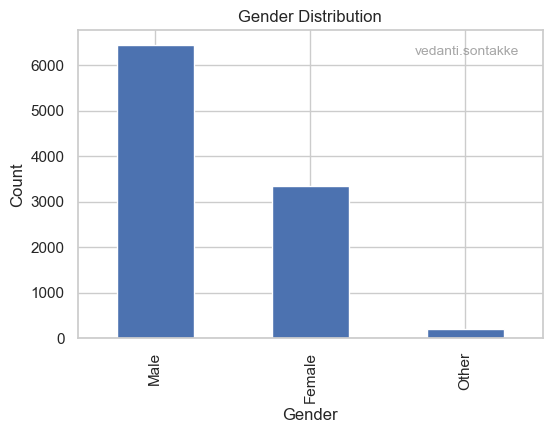

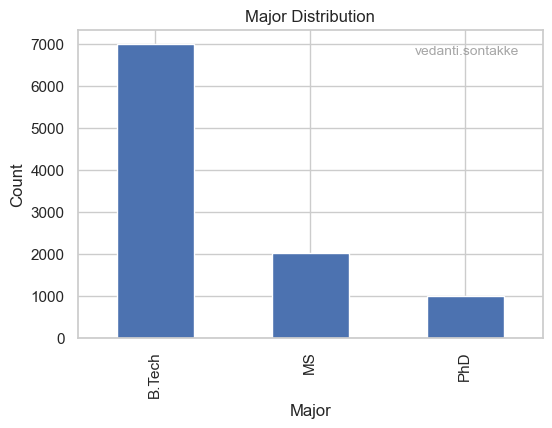

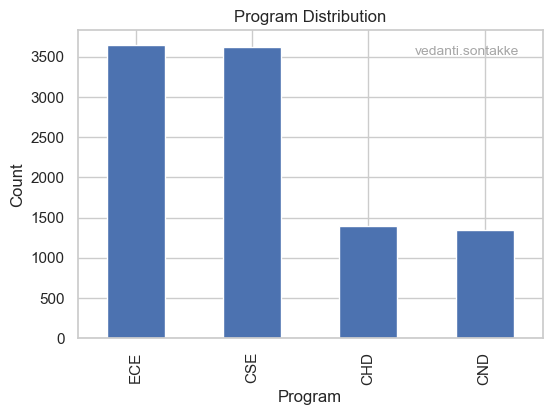

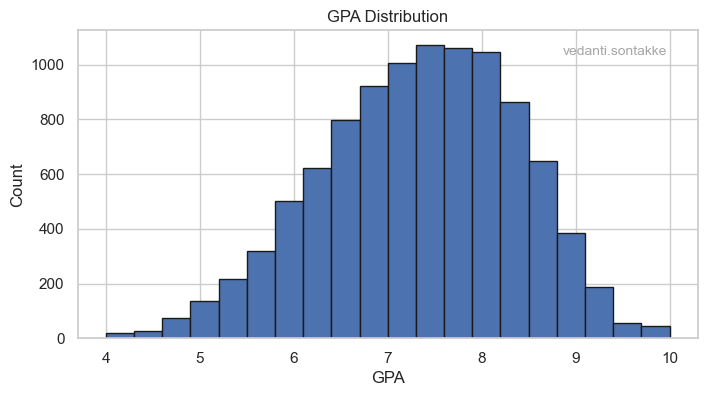

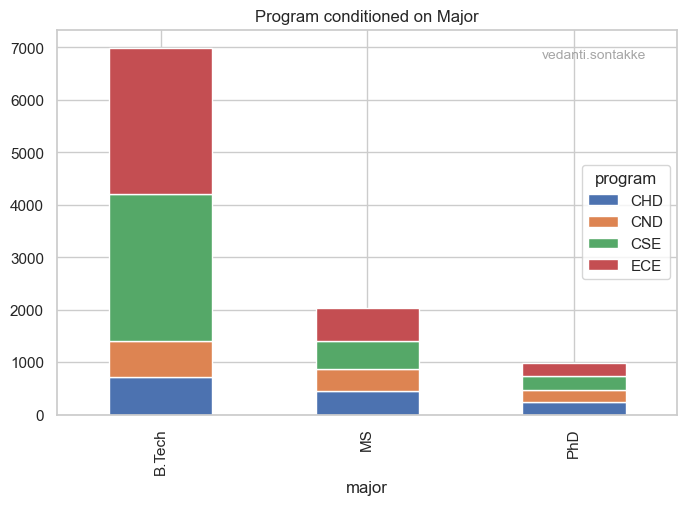

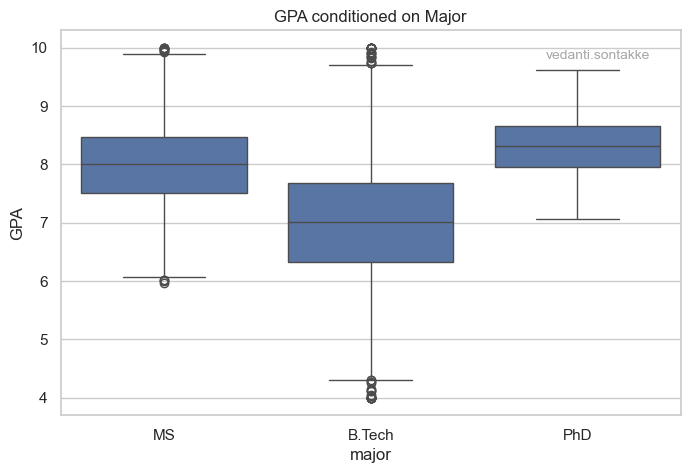

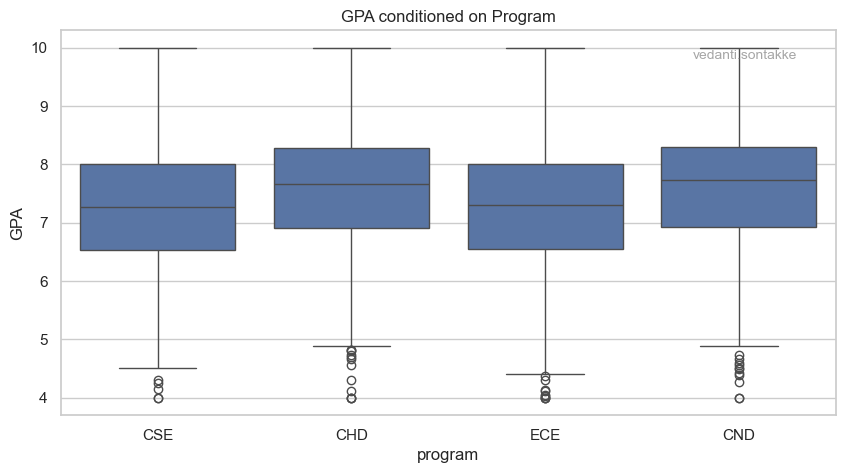

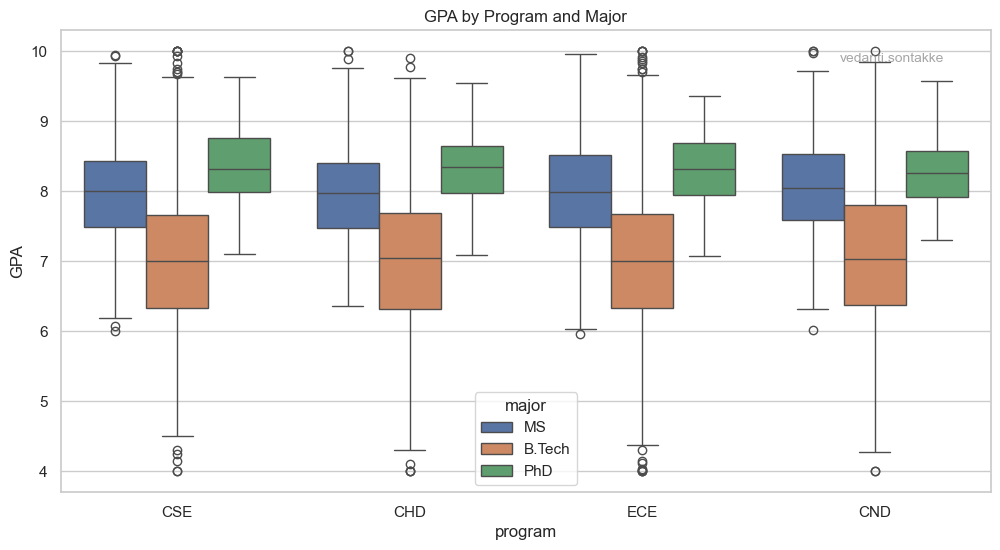

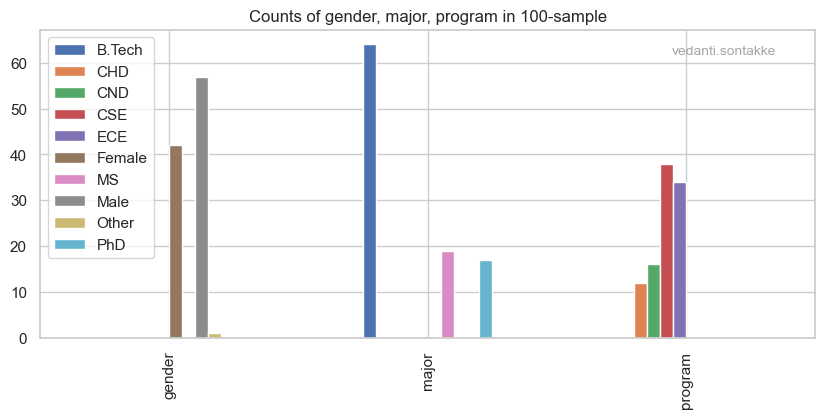

In [6]:
# Cell 6: Visualizations for Q1.1a

def plot_gender_distribution(df):
    fig, ax = plt.subplots(figsize=(6,4))
    df.gender.value_counts().plot(kind='bar', ax=ax)
    ax.set_title("Gender Distribution")
    ax.set_xlabel("Gender")
    ax.set_ylabel("Count")
    add_username_watermark(ax)
    plt.show()

def plot_major_distribution(df):
    fig, ax = plt.subplots(figsize=(6,4))
    df.major.value_counts().plot(kind='bar', ax=ax)
    ax.set_title("Major Distribution")
    ax.set_xlabel("Major")
    ax.set_ylabel("Count")
    add_username_watermark(ax)
    plt.show()

def plot_program_distribution(df):
    fig, ax = plt.subplots(figsize=(6,4))
    df.program.value_counts().plot(kind='bar', ax=ax)
    ax.set_title("Program Distribution")
    ax.set_xlabel("Program")
    ax.set_ylabel("Count")
    add_username_watermark(ax)
    plt.show()

def plot_gpa_distribution(df, bins=20):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(df.GPA, bins=bins, edgecolor='k')
    ax.set_title("GPA Distribution")
    ax.set_xlabel("GPA")
    ax.set_ylabel("Count")
    add_username_watermark(ax)
    plt.show()

def plot_program_by_major(df):
    ctab = pd.crosstab(df.major, df.program)
    fig, ax = plt.subplots(figsize=(8,5))
    ctab.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title("Program conditioned on Major")
    add_username_watermark(ax)
    plt.show()

def plot_gpa_by_major(df):
    fig, ax = plt.subplots(figsize=(8,5))
    sns.boxplot(x='major', y='GPA', data=df, ax=ax)
    ax.set_title("GPA conditioned on Major")
    add_username_watermark(ax)
    plt.show()

def plot_gpa_by_program(df):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.boxplot(x='program', y='GPA', data=df, ax=ax)
    ax.set_title("GPA conditioned on Program")
    add_username_watermark(ax)
    plt.show()

def plot_gpa_by_program_and_major(df):
    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(x='program', y='GPA', hue='major', data=df, ax=ax)
    ax.set_title("GPA by Program and Major")
    add_username_watermark(ax)
    plt.show()

def plot_sampled_100(df):
    sample = df.sample(n=100, random_state=sd.seed)
    fig, ax = plt.subplots(figsize=(10,4))
    sample[['gender','major','program']].apply(lambda x: x.value_counts()).T.fillna(0).plot(kind='bar', ax=ax)
    ax.set_title("Counts of gender, major, program in 100-sample")
    add_username_watermark(ax)
    plt.show()
    return sample

def plot_entire_dataset_summary(df):
    # pairplot can be heavy, show small pairplot using GPA and encoded categories counts
    enc = pd.get_dummies(df[['major','program','gender']])
    small = pd.concat([df[['GPA']].reset_index(drop=True), enc.reset_index(drop=True)], axis=1)
    sns.pairplot(small.sample(n=500, random_state=sd.seed))
    plt.suptitle("Pairplot (subset)", y=1.02)
    plt.show()

# Run the plotting functions
plot_gender_distribution(df)
plot_major_distribution(df)
plot_program_distribution(df)
plot_gpa_distribution(df)
plot_program_by_major(df)
plot_gpa_by_major(df)
plot_gpa_by_program(df)
plot_gpa_by_program_and_major(df)
sample100 = plot_sampled_100(df)
# Note: pairplot may take time; uncomment if OK
# plot_entire_dataset_summary(df)


Full dataset GPA mean: 7.335 std: 1.036

Counts per (program, major) pair:
 major    B.Tech   MS  PhD
program                  
CHD         709  445  241
CND         686  421  235
CSE        2818  537  261
ECE        2776  625  246


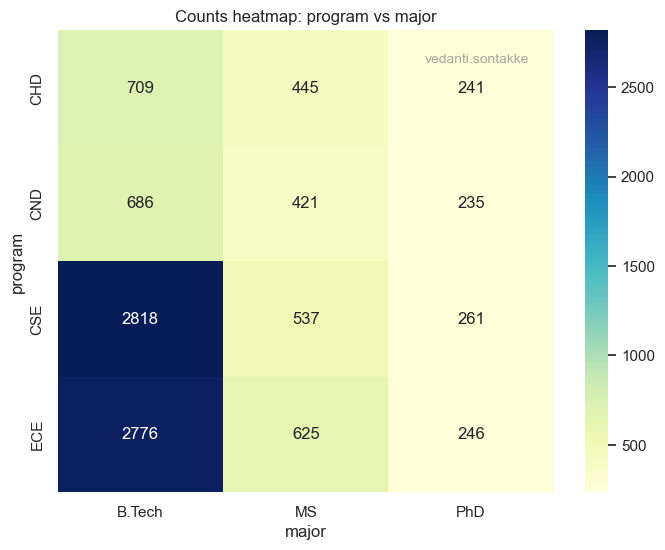

In [7]:
# Cell 7: GPA mean/std and program-major counts
def gpa_mean_std(df):
    return df.GPA.mean(), df.GPA.std()

mean_gpa, std_gpa = gpa_mean_std(df)
print("Full dataset GPA mean:", round(mean_gpa,3), "std:", round(std_gpa,3))

def count_students_per_program_major_pair(df):
    counts = df.groupby(['program','major']).size().unstack(fill_value=0)
    return counts

counts_df = count_students_per_program_major_pair(df)
print("\nCounts per (program, major) pair:\n", counts_df)

def visualize_students_per_program_major_pair(counts_df):
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(counts_df, annot=True, fmt='d', cmap='YlGnBu', ax=ax)
    ax.set_title("Counts heatmap: program vs major")
    add_username_watermark(ax)
    plt.show()

visualize_students_per_program_major_pair(counts_df)


In [9]:
# Cell 8 (Fixed): Simple vs Stratified sampling comparisons

def get_gpa_mean_std_random(df, n=500, repeats=50, seed=seed):
    rng_local = np.random.default_rng(seed)
    means = []
    for _ in range(repeats):
        sample = df.sample(n=n, replace=False, random_state=rng_local.integers(0, 2**31))
        means.append(sample.GPA.mean())
    return np.mean(means), np.std(means), means


def get_gpa_mean_std_stratified(df, n=500, repeats=50, seed=seed):
    rng_local = np.random.default_rng(seed)
    means = []
    majors = df.major.unique()
    prop = df.major.value_counts(normalize=True)
    for _ in range(repeats):
        parts = []
        total = 0
        # proportional sampling per major
        for m in majors:
            k = int(round(prop[m] * n))
            subset = df[df.major == m]
            # ensure we don't exceed available rows
            if k > len(subset):
                k = len(subset)
            total += k
            part = subset.sample(n=k, replace=False, random_state=rng_local.integers(0, 2**31))
            parts.append(part)
        sample = pd.concat(parts)
        # adjust to exactly n rows if total slightly off
        if len(sample) > n:
            sample = sample.sample(n=n, random_state=rng_local.integers(0, 2**31))
        elif len(sample) < n:
            extra = df.sample(n=(n - len(sample)), replace=True, random_state=rng_local.integers(0, 2**31))
            sample = pd.concat([sample, extra])
        means.append(sample.GPA.mean())
    return np.mean(means), np.std(means), means


# --- Run and compare
mean_rand, std_rand, _ = get_gpa_mean_std_random(df)
mean_strat, std_strat, _ = get_gpa_mean_std_stratified(df)

print("Random Sampling:     avg mean GPA = {:.4f}, std of sample means = {:.5f}".format(mean_rand, std_rand))
print("Stratified Sampling: avg mean GPA = {:.4f}, std of sample means = {:.5f}".format(mean_strat, std_strat))


Random Sampling:     avg mean GPA = 7.3283, std of sample means = 0.05181
Stratified Sampling: avg mean GPA = 7.3462, std of sample means = 0.03653


Balanced exact counts (repeats):
{'Female': 100, 'Male': 100, 'Other': 100}
{'Female': 100, 'Other': 100, 'Male': 100}
{'Male': 100, 'Female': 100, 'Other': 100}
{'Female': 100, 'Other': 100, 'Male': 100}
{'Other': 100, 'Male': 100, 'Female': 100}

Strategy A counts (repeats):
{'Female': 122, 'Male': 91, 'Other': 87}
{'Other': 110, 'Female': 106, 'Male': 84}
{'Other': 108, 'Female': 96, 'Male': 96}
{'Male': 110, 'Female': 97, 'Other': 93}
{'Female': 109, 'Male': 103, 'Other': 88}


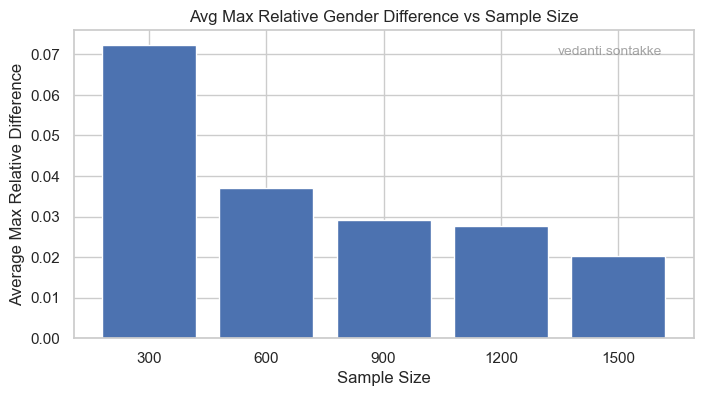

In [10]:
# Cell 9: Gender-balanced cohort sampling

def get_gender_balanced_counts(df, n=300, repeats=5):
    rng_local = np.random.default_rng(seed)
    genders = df.gender.unique()
    k_per = n // len(genders)
    results = []
    for _ in range(repeats):
        parts = []
        for g in genders:
            avail = df[df.gender==g]
            if len(avail) < k_per:
                part = avail.sample(n=k_per, replace=True, random_state=rng_local.integers(0,2**31))
            else:
                part = avail.sample(n=k_per, replace=False, random_state=rng_local.integers(0,2**31))
            parts.append(part)
        sampled = pd.concat(parts).sample(frac=1, random_state=rng_local.integers(0,2**31))
        counts = sampled.gender.value_counts().to_dict()
        results.append(counts)
    return results

def sample_gender_uniform_random(df, n=300, repeats=5):
    rng_local = np.random.default_rng(seed)
    genders = df.gender.unique()
    results = []
    for _ in range(repeats):
        chosen = []
        # Strategy A: pick a gender uniformly and then pick a random student from that gender
        for _ in range(n):
            g = rng_local.choice(genders)
            student = df[df.gender==g].sample(n=1, random_state=rng_local.integers(0,2**31))
            chosen.append(student)
        sampled = pd.concat(chosen)
        results.append(sampled.gender.value_counts().to_dict())
    return results

balanced_counts = get_gender_balanced_counts(df)
strategyA_counts = sample_gender_uniform_random(df)

print("Balanced exact counts (repeats):")
for row in balanced_counts:
    print(row)
print("\nStrategy A counts (repeats):")
for row in strategyA_counts:
    print(row)

# For sample sizes [300,600,900,1200,1500]
def plot_avg_max_gender_diff_vs_sample_size(df, sample_sizes=[300,600,900,1200,1500], repeats=10):
    rng_local = np.random.default_rng(seed)
    genders = df.gender.unique()
    avg_max_rel_diffs = []
    for n in sample_sizes:
        max_rel_per_repeat = []
        for _ in range(repeats):
            chosen_counts = []
            for _r in range(n):
                g = rng_local.choice(genders)
                # pick student from that gender
                chosen_counts.append(g)
            c = Counter(chosen_counts)
            max_count = max(c.values())
            min_count = min(c.values())
            max_rel = (max_count - min_count) / n
            max_rel_per_repeat.append(max_rel)
        avg = np.mean(max_rel_per_repeat)
        avg_max_rel_diffs.append(avg)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar([str(s) for s in sample_sizes], avg_max_rel_diffs)
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Average Max Relative Difference")
    ax.set_title("Avg Max Relative Gender Difference vs Sample Size")
    add_username_watermark(ax)
    plt.show()

plot_avg_max_gender_diff_vs_sample_size(df)


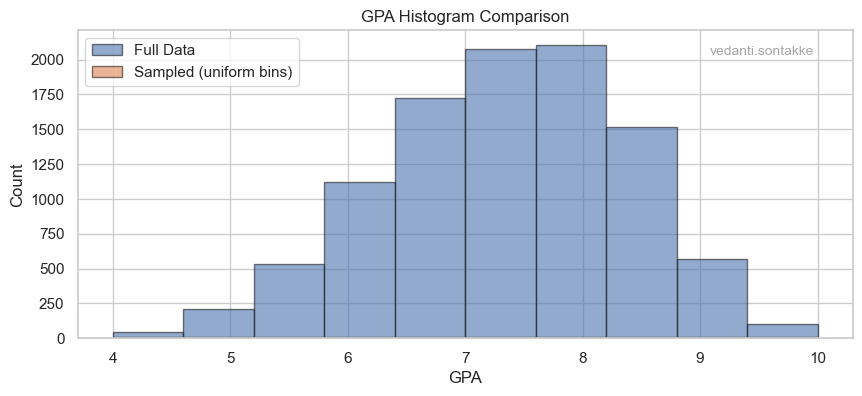

In [11]:
# Cell 10: GPA uniform sampling across bins
def sample_gpa_uniform(df, n=100, bins=10):
    rng_local = np.random.default_rng(seed)
    df = df.copy()
    df['gpa_bin'] = pd.cut(df.GPA, bins=bins, labels=False, include_lowest=True)
    per_bin = max(1, n // bins)
    parts = []
    for b in range(bins):
        avail = df[df.gpa_bin == b]
        if len(avail) >= per_bin:
            parts.append(avail.sample(n=per_bin, random_state=rng_local.integers(0,2**31)))
        else:
            # if insufficient, sample with replacement
            parts.append(avail.sample(n=per_bin, replace=True, random_state=rng_local.integers(0,2**31)))
    sampled = pd.concat(parts).sample(n=n, random_state=rng_local.integers(0,2**31))
    sampled.drop(columns=['gpa_bin'], inplace=True)
    return sampled

def plot_gpa_histogram_comparison(df, sampled_df, bins=10):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(df.GPA, bins=bins, alpha=0.6, label='Full Data', edgecolor='k')
    ax.hist(sampled_df.GPA, bins=bins, alpha=0.6, label='Sampled (uniform bins)', edgecolor='k')
    ax.set_title("GPA Histogram Comparison")
    ax.set_xlabel("GPA")
    ax.set_ylabel("Count")
    ax.legend()
    add_username_watermark(ax)
    plt.show()

sampled_gpa_uniform = sample_gpa_uniform(df, n=100, bins=10)
plot_gpa_histogram_comparison(df, sampled_gpa_uniform)
# We sampled **with replacement** only when a bin had insufficient samples to reach per-bin target.


major    B.Tech  MS  PhD
program                 
CHD           5   5    5
CND           5   5    5
CSE           5   5    5
ECE           5   5    5


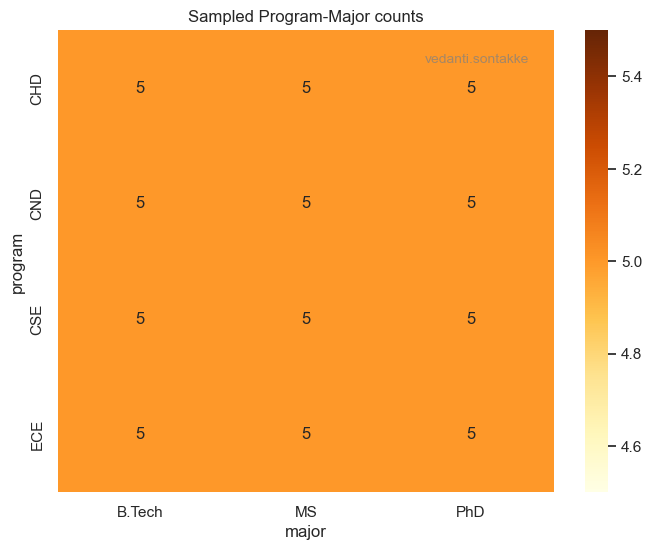

In [12]:
# Cell 11: Program-major balanced sampling (Strategy A)
def sample_program_major_balanced(df, n=60):
    rng_local = np.random.default_rng(seed)
    combos = df.groupby(['program','major']).size().reset_index().rename(columns={0:'count'})
    valid_combos = combos[['program','major']].values.tolist()
    k = max(1, n // len(valid_combos))
    parts = []
    for prog, maj in valid_combos:
        avail = df[(df.program==prog) & (df.major==maj)]
        if len(avail) >= k:
            parts.append(avail.sample(n=k, random_state=rng_local.integers(0,2**31)))
        else:
            parts.append(avail.sample(n=k, replace=True, random_state=rng_local.integers(0,2**31)))
    sampled = pd.concat(parts).sample(n=n, random_state=rng_local.integers(0,2**31))
    return sampled

def show_program_major_counts_and_heatmap(sampled_df):
    counts = sampled_df.groupby(['program','major']).size().unstack(fill_value=0)
    print(counts)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(counts, annot=True, fmt='d', cmap='YlOrBr', ax=ax)
    ax.set_title("Sampled Program-Major counts")
    add_username_watermark(ax)
    plt.show()

sample_pm = sample_program_major_balanced(df, n=60)
show_program_major_counts_and_heatmap(sample_pm)
# If any group was too small, sampling with replacement was used.


In [26]:
# Cell 12 (Fixed): PerFeatureTransformer class definition

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

class PerFeatureTransformer:
    def __init__(self):
        self.column_transformer = None
        self.feature_order = []
        self.feature_types = {}

    # ---- FIXED fit() method ----
    def fit(self, df, params):
        """
        params: dict mapping column -> transformation type: 'standard', 'onehot', 'ordinal'
        """
        self.feature_order = list(params.keys())
        self.feature_types = params.copy()

        numeric_feats = [f for f, t in params.items() if t == 'standard']
        onehot_feats  = [f for f, t in params.items() if t == 'onehot']
        ordinal_feats = [f for f, t in params.items() if t == 'ordinal']

        transformers = []
        if numeric_feats:
            transformers.append(('num', StandardScaler(), numeric_feats))

        if onehot_feats:
            # compatible with all sklearn versions
            try:
                ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # ≥1.6
            except TypeError:
                ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')         # <1.6
            transformers.append(('ohe', ohe, onehot_feats))

        if ordinal_feats:
            transformers.append(('ord', OrdinalEncoder(), ordinal_feats))

        if transformers:
            self.column_transformer = ColumnTransformer(transformers, remainder='drop')
            self.column_transformer.fit(df)
        else:
            self.column_transformer = None

    # ---- transform() ----
    def transform(self, df):
        if self.column_transformer is None:
            return df.values
        return self.column_transformer.transform(df)

    # ---- fit_transform() helper ----
    def fit_transform(self, df, params):
        self.fit(df, params)
        return self.transform(df)


In [27]:
# Cell 13: KNNGenderPredictor

class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str = username):
        self.df = student_df.reset_index(drop=True).copy()
        self.username = username
        self.seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
        self.rng = np.random.default_rng(self.seed)
        self.transformer = None
        self.X_train = self.X_val = self.X_test = None
        self.y_train = self.y_val = self.y_test = None
    
    def train_val_test_split(self, test_size: float=0.2, val_size: float=0.2, seed: int=None):
        seed = self.seed if seed is None else seed
        # stratify by gender for balanced sets
        X = self.df.drop(columns=[])
        y = self.df.gender
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
        # now split X_temp into train and val
        val_rel = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_rel, random_state=seed, stratify=y_temp)
        self.X_train, self.X_val, self.X_test = X_train.reset_index(drop=True), X_val.reset_index(drop=True), X_test.reset_index(drop=True)
        self.y_train, self.y_val, self.y_test = y_train.reset_index(drop=True), y_val.reset_index(drop=True), y_test.reset_index(drop=True)
        return self.X_train, self.X_val, self.X_test
    
    def get_feature_matrix_and_labels(self, df: pd.DataFrame, features: List[str], fit_transform: bool = False):
        """
        features: subset of columns from ['GPA', 'major', 'program', ...]
        fit_transform: if True, fit the transformer on training data.
        """
        # build params for each feature
        params = {}
        for f in features:
            if f == 'GPA':
                params[f] = 'standard'
            elif f in ['major', 'program', 'gender']:
                params[f] = 'onehot' if f != 'major' else 'ordinal'  # major ordinal vs program onehot example
            else:
                # default treat as onehot
                params[f] = 'onehot'
        
        if fit_transform:
            self.transformer = PerFeatureTransformer()
            self.transformer.fit(df[features], params)
            X = self.transformer.transform(df[features])
        else:
            X = self.transformer.transform(df[features])
        # labels: map gender to numeric
        label_map = {"Male":0, "Female":1, "Other":2}
        if 'gender' in df.columns:
            y = df.gender.map(label_map).values
        else:
            y = None
        return X, y
    
    def get_knn_accuracy_vs_k(self, k_values: List[int], distance: str='euclidean'):
        # Fit transformer on train using selected features: use all features except gender
        features = ['GPA','major','program']
        X_train, _ = self.get_feature_matrix_and_labels(self.X_train, features, fit_transform=True)
        X_val, y_val = self.get_feature_matrix_and_labels(self.X_val, features, fit_transform=False)
        y_train = self.y_train.map({'Male':0,'Female':1,'Other':2}).values
        y_val = self.y_val.map({'Male':0,'Female':1,'Other':2}).values
        
        accs = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(X_train, y_train)
            preds = knn.predict(X_val)
            accs.append(accuracy_score(y_val, preds))
        return accs
    
    def plot_knn_accuracy_vs_k(self, k_values, distance='euclidean'):
        accs = self.get_knn_accuracy_vs_k(k_values, distance)
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(k_values, accs, marker='o')
        ax.set_xlabel("k")
        ax.set_ylabel("Validation Accuracy")
        ax.set_title(f"KNN accuracy vs k ({distance})")
        add_username_watermark(ax)
        plt.show()
    
    def get_knn_f1_heatmap(self, k_values: List[int], distances: List[str]):
        features = ['GPA','major','program']
        X_train, _ = self.get_feature_matrix_and_labels(self.X_train, features, fit_transform=True)
        X_val, _ = self.get_feature_matrix_and_labels(self.X_val, features, fit_transform=False)
        y_train = self.y_train.map({'Male':0,'Female':1,'Other':2}).values
        y_val = self.y_val.map({'Male':0,'Female':1,'Other':2}).values
        
        data = []
        for metric in distances:
            row = []
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
                knn.fit(X_train, y_train)
                preds = knn.predict(X_val)
                f1 = f1_score(y_val, preds, average='weighted', zero_division=0)
                row.append(f1)
            data.append(row)
        df_heat = pd.DataFrame(data, index=distances, columns=k_values)
        return df_heat
    
    def plot_knn_f1_heatmap(self, f1_scores_df):
        fig, ax = plt.subplots(figsize=(10,4))
        sns.heatmap(f1_scores_df, annot=True, fmt=".3f", ax=ax, cmap='viridis')
        ax.set_title("K x Distance metric: Validation F1 scores")
        add_username_watermark(ax)
        plt.show()
    
    def get_knn_f1_single_feature_table(self, k_values: List[int], features: List[str], distance: str='euclidean'):
        # Evaluate using a single feature at a time on test set
        results = pd.DataFrame(index=k_values, columns=features)
        # fit transformer on training data per single feature
        for feat in features:
            # fit transformer on train for this feature
            self.transformer = PerFeatureTransformer()
            self.transformer.fit(self.X_train[[feat]], {feat: 'standard' if feat=='GPA' else 'onehot'})
            X_train = self.transformer.transform(self.X_train[[feat]])
            X_test = self.transformer.transform(self.X_test[[feat]])
            y_train = self.y_train.map({'Male':0,'Female':1,'Other':2}).values
            y_test = self.y_test.map({'Male':0,'Female':1,'Other':2}).values
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
                knn.fit(X_train, y_train)
                preds = knn.predict(X_test)
                results.loc[k, feat] = f1_score(y_test, preds, average='weighted', zero_division=0)
        return results.astype(float)


Euclidean best k (val acc): 19 acc: 0.6225
Manhattan best k (val acc): 19 acc: 0.6225
Cosine best k (val acc): 21 acc: 0.623


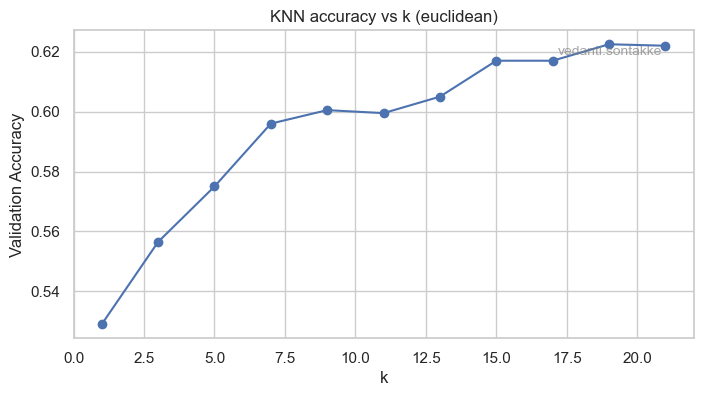

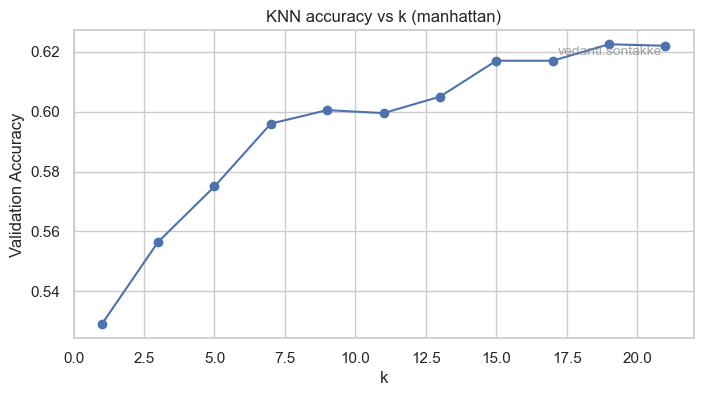

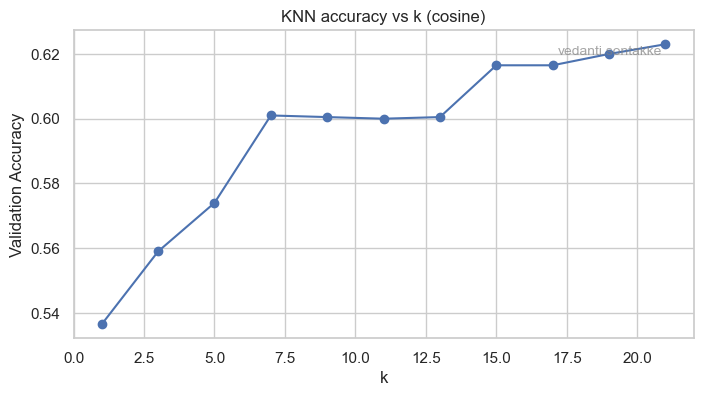


Validation F1 scores (heatmap):
                  1         3         5         7         9         11  \
euclidean  0.529891  0.539363  0.546082  0.555063  0.549436  0.535217   
manhattan  0.529891  0.539133  0.546082  0.555063  0.549436  0.535217   
cosine     0.538184  0.541262  0.546814  0.559282  0.547970  0.536027   

                 13        15        17        19        21  
euclidean  0.535420  0.539459  0.535370  0.531050  0.522453  
manhattan  0.535420  0.539459  0.535370  0.531050  0.522453  
cosine     0.530957  0.539679  0.533337  0.527024  0.522921  


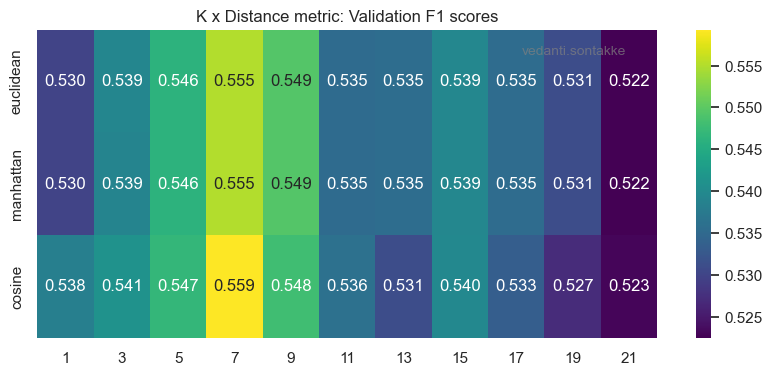


Single-feature F1 table (euclidean) on test set:
          GPA     major   program
1   0.534241  0.537084  0.505175
3   0.545542  0.505175  0.505175
5   0.555290  0.505175  0.505175
7   0.547543  0.505175  0.545548
9   0.544383  0.505175  0.545548
11  0.534038  0.505175  0.505175
13  0.530637  0.505175  0.505175
15  0.534667  0.505175  0.505175
17  0.530755  0.505175  0.505175
19  0.528993  0.505175  0.505175
21  0.512009  0.505175  0.505175


In [28]:
# Cell 14: Run KNN experiments

kp = KNNGenderPredictor(df, username=username)
kp.train_val_test_split(test_size=0.2, val_size=0.2)

k_values = list(range(1,22,2))  # odd 1..21

# Euclidean
acc_euc = kp.get_knn_accuracy_vs_k(k_values, distance='euclidean')
best_k_euc = k_values[int(np.argmax(acc_euc))]
print("Euclidean best k (val acc):", best_k_euc, "acc:", max(acc_euc))

# Manhattan
acc_man = kp.get_knn_accuracy_vs_k(k_values, distance='manhattan')
best_k_man = k_values[int(np.argmax(acc_man))]
print("Manhattan best k (val acc):", best_k_man, "acc:", max(acc_man))

# Cosine
acc_cos = kp.get_knn_accuracy_vs_k(k_values, distance='cosine')
best_k_cos = k_values[int(np.argmax(acc_cos))]
print("Cosine best k (val acc):", best_k_cos, "acc:", max(acc_cos))

# Plotting accuracy vs k for euclidean
kp.plot_knn_accuracy_vs_k(k_values, distance='euclidean')
kp.plot_knn_accuracy_vs_k(k_values, distance='manhattan')
kp.plot_knn_accuracy_vs_k(k_values, distance='cosine')

# F1 heatmap across distances and k
f1_df = kp.get_knn_f1_heatmap(k_values, ['euclidean','manhattan','cosine'])
print("\nValidation F1 scores (heatmap):\n", f1_df)
kp.plot_knn_f1_heatmap(f1_df)

# Single-feature F1 table on test set (for all distance metrics, we show for euclidean for example)
single_feats = ['GPA','major','program']
single_f1_euc = kp.get_knn_f1_single_feature_table(k_values, single_feats, distance='euclidean')
print("\nSingle-feature F1 table (euclidean) on test set:\n", single_f1_euc)


In [29]:
# Cell 15: Short analysis (printout)
print("Best validation accuracies:")
print("Euclidean:", max(acc_euc), "at k", best_k_euc)
print("Manhattan:", max(acc_man), "at k", best_k_man)
print("Cosine:", max(acc_cos), "at k", best_k_cos)

print("\nObservation hint: Check F1 heatmap and single-feature table to decide which metric performs better. ")


Best validation accuracies:
Euclidean: 0.6225 at k 19
Manhattan: 0.6225 at k 19
Cosine: 0.623 at k 21

Observation hint: Check F1 heatmap and single-feature table to decide which metric performs better. 


In [30]:
# Cell 16: Helper to run polynomial regression with optional L1/L2 (Lasso/Ridge)

def run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                        degree=1, regularizer=None, reg_strength=0.0):
    """
    Fits polynomial regression (degree) with optional regularization.
    regularizer: None, 'l1', 'l2'
    reg_strength: alpha (for L1/L2)
    """
    # pipeline
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    if regularizer is None:
        model = LinearRegression()
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength)
    elif regularizer == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=10000)
    else:
        raise ValueError("regularizer must be None, 'l1', or 'l2'")
    
    pipeline = Pipeline([('poly', poly), ('lr', model)])
    pipeline.fit(X_train, y_train)
    # predictions and mse
    train_pred = pipeline.predict(X_train)
    val_pred = pipeline.predict(X_val)
    test_pred = pipeline.predict(X_test)
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    # Return coefficients where applicable (for linear model)
    coefs = None
    try:
        coefs = pipeline.named_steps['lr'].coef_
    except:
        coefs = None
    
    return {
        'degree': degree, 'regularizer': regularizer, 'reg_strength': reg_strength,
        'train_mse': train_mse, 'val_mse': val_mse, 'test_mse': test_mse,
        'model': pipeline, 'coefs': coefs
    }


In [31]:
# Cell 17: Prepare feature matrix for regression and do train/val/test splits (re-using kp splits for consistency)
# We'll predict GPA using features: major (one-hot), program (one-hot), gender (one-hot)
full = df.copy()
# Convert categorical to dummies for regression
X_full = pd.get_dummies(full[['major','program','gender']], drop_first=True)
y_full = full.GPA.values

# Use the same train/val/test indices from KNN predictor to keep consistency
train_idx = kp.X_train.index
val_idx = kp.X_val.index
test_idx = kp.X_test.index

X_train = X_full.loc[train_idx].values
X_val = X_full.loc[val_idx].values
X_test = X_full.loc[test_idx].values
y_train = y_full[train_idx]
y_val = y_full[val_idx]
y_test = y_full[test_idx]

print("Shapes: ", X_train.shape, X_val.shape, X_test.shape)


Shapes:  (6000, 7) (2000, 7) (2000, 7)


In [32]:
# Cell 18: Evaluate degrees 1..6 for no regularization, L1, L2
degrees = list(range(1,7))
reg_strengths = np.logspace(-4, 2, 10)

results = []

for reg in [None, 'l1', 'l2']:
    for degree in degrees:
        # For each degree, tune reg_strength if regularizer is not None
        if reg is None:
            res = run_poly_regression(X_train,y_train,X_val,y_val,X_test,y_test, degree=degree, regularizer=None)
            results.append(res)
        else:
            # pick best alpha by validation mse
            best = None
            for alpha in reg_strengths:
                r = run_poly_regression(X_train,y_train,X_val,y_val,X_test,y_test, degree=degree, regularizer=reg, reg_strength=alpha)
                if best is None or r['val_mse'] < best['val_mse']:
                    best = r
            results.append(best)

# Collect results into DataFrame
res_df = pd.DataFrame(results)
res_df.head()


,degree,regularizer,reg_strength,train_mse,val_mse,test_mse,model,coefs
0,1,None,0.0,0.825295,0.816563,0.816563,"(PolynomialFeatures(degree=1, include_bias=Fal...","[0.968151297873166, 1.283231767843247, 0.00257..."
1,2,None,0.0,0.824614,0.815433,0.815433,"(PolynomialFeatures(include_bias=False), Linea...","[0.44541743958859165, 0.6137119282525106, -0.0..."
2,3,None,0.0,0.823748,0.814344,0.814344,"(PolynomialFeatures(degree=3, include_bias=Fal...","[0.2650952277395174, 0.4023620469932291, -0.02..."
3,4,None,0.0,0.823748,0.814344,0.814344,"(PolynomialFeatures(degree=4, include_bias=Fal...","[0.19882142080464038, 0.3017715352449258, -0.0..."
4,5,None,0.0,0.823748,0.814344,0.814344,"(PolynomialFeatures(degree=5, include_bias=Fal...","[0.15905713664371277, 0.24141722819594114, -0...."


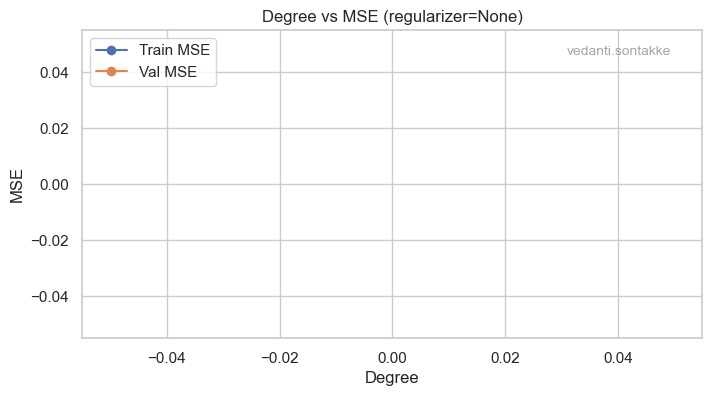

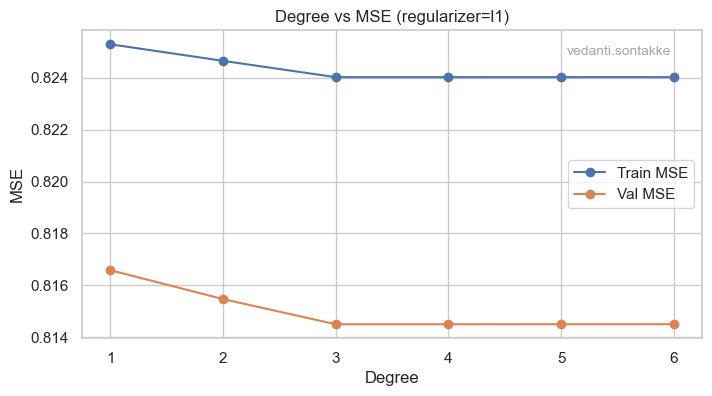

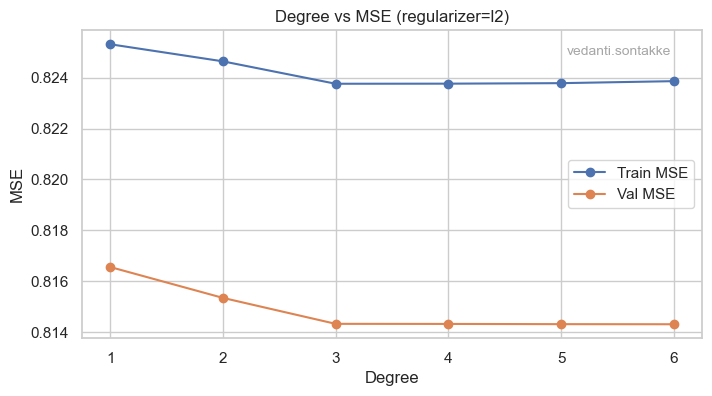

In [33]:
# Cell 19: Plotting degree vs MSE (train & val) for each regularizer
for reg in [None, 'l1', 'l2']:
    subset = res_df[res_df.regularizer == reg]
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(subset.degree, subset.train_mse, marker='o', label='Train MSE')
    ax.plot(subset.degree, subset.val_mse, marker='o', label='Val MSE')
    ax.set_xlabel("Degree")
    ax.set_ylabel("MSE")
    ax.set_title(f"Degree vs MSE (regularizer={reg})")
    ax.legend()
    add_username_watermark(ax)
    plt.show()


Best degree for l1 by validation MSE: 4


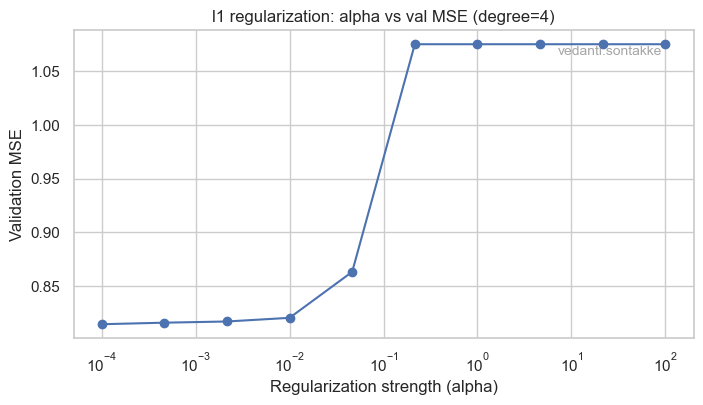

Best degree for l2 by validation MSE: 6


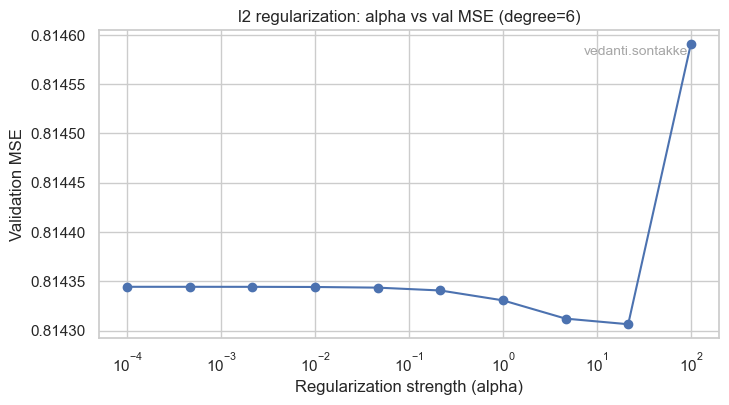

In [34]:
# Cell 20: For each regularizer (l1,l2) find best degree then plot alpha vs val MSE
for reg in ['l1','l2']:
    # find degree with lowest val_mse in res_df for that reg
    subset_all = res_df[res_df.regularizer == reg]
    best_degree = int(subset_all.loc[subset_all.val_mse.idxmin()].degree)
    print(f"Best degree for {reg} by validation MSE: {best_degree}")
    # now sweep alphas for that degree
    val_mses = []
    alphas = reg_strengths
    for alpha in alphas:
        r = run_poly_regression(X_train,y_train,X_val,y_val,X_test,y_test, degree=best_degree, regularizer=reg, reg_strength=alpha)
        val_mses.append(r['val_mse'])
    fig, ax = plt.subplots(figsize=(8,4))
    ax.semilogx(alphas, val_mses, marker='o')
    ax.set_xlabel("Regularization strength (alpha)")
    ax.set_ylabel("Validation MSE")
    ax.set_title(f"{reg} regularization: alpha vs val MSE (degree={best_degree})")
    add_username_watermark(ax)
    plt.show()


In [35]:
# Cell 21: Find best setup by val MSE and report test MSE, and list non-zero weights for L1 and L2 best models
best_by_val = res_df.loc[res_df.val_mse.idxmin()]
print("Best overall by validation MSE:")
print(best_by_val[['regularizer','degree','reg_strength','train_mse','val_mse','test_mse']])

# For best L1 and L2 setups, show coefficients (use models run earlier in result list or re-run)
for reg in ['l1','l2']:
    subset_all = res_df[res_df.regularizer == reg]
    best = subset_all.loc[subset_all.val_mse.idxmin()]
    degree = int(best.degree)
    alpha = best.reg_strength
    model_info = run_poly_regression(X_train,y_train,X_val,y_val,X_test,y_test, degree=degree, regularizer=reg, reg_strength=alpha)
    coefs = model_info['coefs']
    print(f"\n{reg} best degree {degree}, alpha {alpha}, test_mse {model_info['test_mse']}")
    # For polynomial features, mapping coef names is complicated; show nonzero indices and their values
    if coefs is not None:
        nz = [(i, round(c,4)) for i,c in enumerate(coefs) if abs(c) > 1e-6]
        print("Non-zero coefficients (index, value):", nz[:20], " ...")
    else:
        print("No coefficients available.")


Best overall by validation MSE:
regularizer            l2
degree                  6
reg_strength    21.544347
train_mse        0.823862
val_mse          0.814306
test_mse         0.814306
Name: 17, dtype: object

l1 best degree 4, alpha 0.0001, test_mse 0.8145009031130024
Non-zero coefficients (index, value): [(0, np.float64(0.7379)), (1, np.float64(1.2031)), (3, np.float64(-0.0517)), (4, np.float64(-0.0721)), (5, np.float64(-0.0079)), (7, np.float64(0.1407)), (9, np.float64(0.0798)), (10, np.float64(0.0716)), (11, np.float64(0.0777)), (12, np.float64(0.0203)), (14, np.float64(0.0319)), (15, np.float64(-0.0307)), (16, np.float64(0.0583)), (17, np.float64(0.0262)), (18, np.float64(0.031)), (20, np.float64(-0.0143)), (23, np.float64(0.0176)), (25, np.float64(-0.0262)), (27, np.float64(0.0045)), (28, np.float64(0.061))]  ...

l2 best degree 6, alpha 21.54434690031882, test_mse 0.8143064674250927
Non-zero coefficients (index, value): [(0, np.float64(0.128)), (1, np.float64(0.188)), (2, np.

In [36]:
# Cell 22: Instructions
print("Notebook cells complete. Replace 'username' variable in Cell 2 if needed.")
print("To prepare for submission: ensure all plots show your username in the corner and run all cells (Kernel -> Restart & Run All).")


Notebook cells complete. Replace 'username' variable in Cell 2 if needed.
To prepare for submission: ensure all plots show your username in the corner and run all cells (Kernel -> Restart & Run All).
